In [ ]:
!pip install transformers datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
    print("GPU is available")
else:
    device = "cpu"
    print("Using device:", device)

GPU is available


In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import warnings

warnings.filterwarnings("ignore")

# Load the model and tokenizer
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Move model to the GPU if available
model.to(device)

print(f"Using device: {device}")

Using device: cuda


In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# Load dataset from a CSV file
dataset = load_dataset('csv', data_files='/content/impression_300_llm.csv')

# Split the dataset into train and evaluation sets
train_data = dataset['train'].select(range(300))
eval_data = dataset['train'].select(range(300, 330))

# Load the GPT-2 model and tokenizer
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Assign a padding token (use eos_token as pad_token)
tokenizer.pad_token = tokenizer.eos_token

# If you added a special [PAD] token, you need to resize the embeddings
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# model.resize_token_embeddings(len(tokenizer))

# Define the tokenization function
def tokenize_function(examples):
    # Concatenate 'Report Name', 'History', and 'Observation' for each example in the batch
    inputs = [rn + " " + h + " " + o for rn, h, o in zip(examples['Report Name'], examples['History'], examples['Observation'])]

    # Tokenize the concatenated input
    model_inputs = tokenizer(inputs, padding='max_length', truncation=True)

    # Tokenize 'Impression' as the target output
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['Impression'], padding='max_length', truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize the dataset
tokenized_train_data = train_data.map(tokenize_function, batched=True)
tokenized_eval_data = eval_data.map(tokenize_function, batched=True)

# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='steps',
    per_device_train_batch_size=2,
    num_train_epochs=3,
    save_steps=10,
    logging_dir='./logs',
    logging_steps=10,
)

# Fine-tune the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_eval_data
)

trainer.train()

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
10,3.177000,0.928936
20,1.348700,0.785330
30,1.300700,0.771311
40,1.253100,0.752750
50,1.451800,0.902250
60,1.409200,0.712483
70,0.993600,0.712804
80,1.380400,0.767553
90,1.108700,0.713774
100,1.027400,0.805123


TrainOutput(global_step=450, training_loss=1.1767853503757053, metrics={'train_runtime': 1121.9681, 'train_samples_per_second': 0.802, 'train_steps_per_second': 0.401, 'total_flos': 470325657600000.0, 'train_loss': 1.1767853503757053, 'epoch': 3.0})

In [15]:
import math
import torch

# Calculate perplexity for the evaluation dataset
def calculate_perplexity(eval_loss):
    return math.exp(eval_loss)

# Evaluate the model on the evaluation dataset
eval_results = trainer.evaluate()

# Get the evaluation loss
eval_loss = eval_results['eval_loss']
perplexity = calculate_perplexity(eval_loss)

print(f"Perplexity: {perplexity}")

Perplexity: 2.094118627427543


In [23]:
!pip install evaluate

In [24]:
!pip install rouge_score

In [26]:
# Function to generate impressions using the fine-tuned model
def generate_impressions(input_text):
    inputs = tokenizer(input_text, return_tensors='pt', truncation=True).to(model.device)  # Remove padding
    outputs = model.generate(**inputs, max_new_tokens=50)  # Specify how many new tokens to generate
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Evaluate ROUGE score for each evaluation sample
rouge_scores = []
for example in eval_data:
    input_text = example['Report Name'] + " " + example['History'] + " " + example['Observation']
    generated_impression = generate_impressions(input_text)
    actual_impression = example['Impression']

    # Compute the ROUGE score
    score = rouge.compute(predictions=[generated_impression], references=[actual_impression])
    rouge_scores.append(score)

# Print the ROUGE results
print(rouge_scores)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

[{'rouge1': 0.5787965616045845, 'rouge2': 0.4610951008645533, 'rougeL': 0.4469914040114613, 'rougeLsum': 0.4469914040114613}, {'rouge1': 0.26993865030674846, 'rouge2': 0.2360248447204969, 'rougeL': 0.26993865030674846, 'rougeLsum': 0.26993865030674846}, {'rouge1': 0.11707317073170732, 'rouge2': 0.03940886699507389, 'rougeL': 0.08780487804878048, 'rougeLsum': 0.08780487804878048}, {'rouge1': 0.5787965616045845, 'rouge2': 0.4610951008645533, 'rougeL': 0.4469914040114613, 'rougeLsum': 0.4469914040114613}, {'rouge1': 0.5045045045045045, 'rouge2': 0.41818181818181815, 'rougeL': 0.44144144144144143, 'rougeLsum': 0.44144144144144143}, {'rouge1': 0.11707317073170732, 'rouge2': 0.03940886699507389, 'rougeL': 0.08780487804878048, 'rougeLsum': 0.08780487804878048}, {'rouge1': 0.26993865030674846, 'rouge2': 0.2360248447204969, 'rougeL': 0.26993865030674846, 'rougeLsum': 0.26993865030674846}, {'rouge1': 0.05128205128205128, 'rouge2': 0.02586206896551724, 'rougeL': 0.05128205128205128, 'rougeLsum': 

In [28]:
# Install necessary libraries
!pip install nltk spacy
!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer

# Load your dataset
dataset = pd.read_csv('/content/impression_300_llm.csv')  # Adjust path as necessary

# Initialize NLP components
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm")

# Text processing function
def process_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and apply stemming
    filtered_tokens = [stemmer.stem(word) for word in tokens if word.lower() not in stop_words]
    return " ".join(filtered_tokens)

# Apply text processing to the entire dataset
dataset['Processed'] = dataset['Report Name'] + " " + dataset['History'] + " " + dataset['Observation']
dataset['Processed'] = dataset['Processed'].apply(process_text)

# Convert processed text to embeddings
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Generate embeddings for all processed texts
dataset['Embeddings'] = dataset['Processed'].apply(get_embeddings)

# Find top 100 pairs of words based on cosine similarity
def get_top_pairs(embeddings):
    # Normalize embeddings
    norm_embeddings = normalize(embeddings)
    sim_matrix = cosine_similarity(norm_embeddings)

    # Find top pairs
    pairs = []
    for i in range(sim_matrix.shape[0]):
        for j in range(i + 1, sim_matrix.shape[1]):
            pairs.append((i, j, sim_matrix[i, j]))

    # Sort pairs by similarity
    top_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:100]
    return top_pairs

# Compute top pairs of word embeddings
top_pairs = get_top_pairs(np.vstack(dataset['Embeddings'].values))

# Output top pairs
print("Top 100 Word Pairs based on Embedding Similarity:")
for pair in top_pairs:
    print(f"Pair: ({dataset['Processed'].iloc[pair[0]]}, {dataset['Processed'].iloc[pair[1]]}) - Similarity: {pair[2]:.4f}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 58.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Top 100 Word Pairs based on Embedding Similarity:
Pair: (ct neck plain contrast 38 year old gentleman . ulcer growth left buccal mucosa last 3 month . progress . nocm . gutka chewer , stop 5 month back . ps 1 , neck node felt . mouth open nad . ulcer growth involv left side lower gb , adjac buccal mucosa . extend onto rmt region . plan : punch biopsi growth . cect face chest . enhanc soft tissu thicken along left inferior gingivobucc sulcu extend involv buccal mucosa overli mandibl maxilla . lesion approxim measur 16 x 10 x 27 mm ( ap x tr x cc ) . minim extens soft tissu thicken left retromolar trigon region . obviou boni eros seen . loss fat plane left masset muscl seen . extens infratempor fossa . enlarg heterogen enhanc left level ib , left level ii cervic lymph node seen , largest measur 16 x 12 mm . subcentimetr size right level ib , subment , right level ii cervic lymph node seen . tm joint normal . mandibl normal nasopharynx , hypopopharnx show normal configur densiti . mildli 

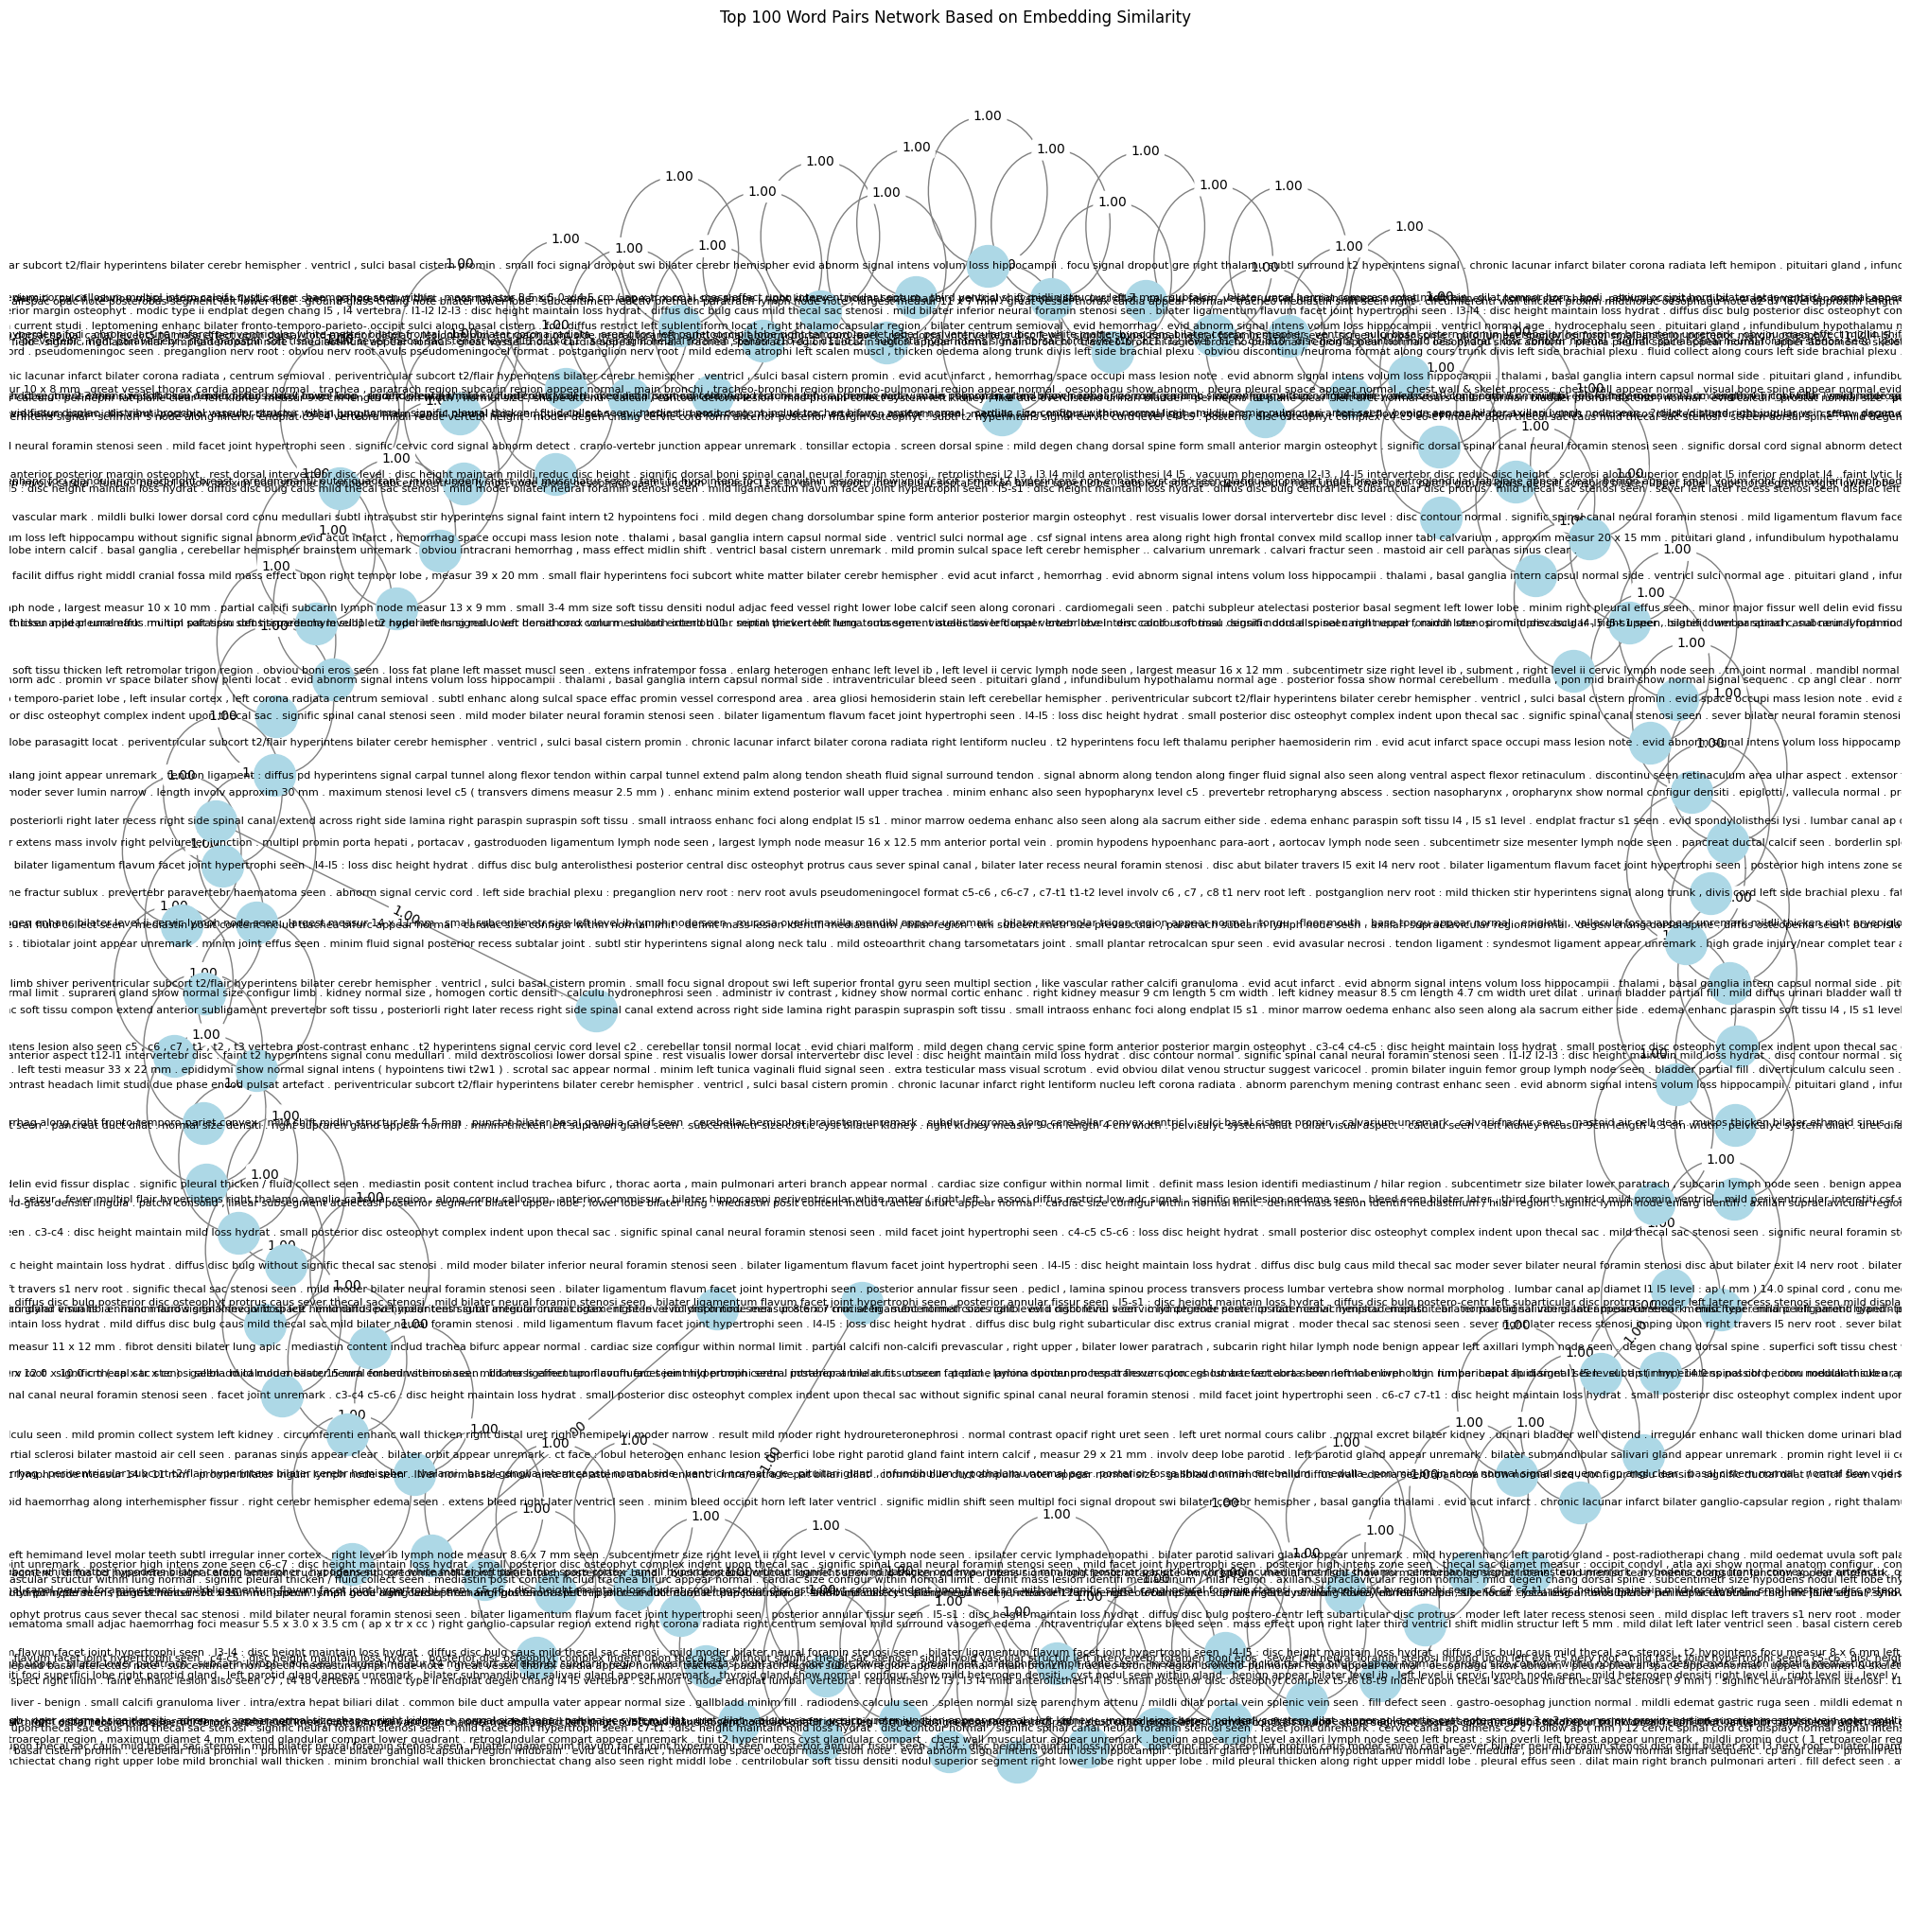

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add edges between word pairs with similarity scores
for i in range(100):
    G.add_edge(words1[i], words2[i], weight=similarities[i])

# Draw the network graph with larger figure size and adjusted layout
plt.figure(figsize=(20, 20))  # Increased figure size
pos = nx.spring_layout(G, k=0.5)  # Adjust k to control the spread of nodes
edges = nx.get_edge_attributes(G, 'weight')

# Reduce node size for better visibility, and change font size
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1000, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edges.items()})

plt.title('Top 100 Word Pairs Network Based on Embedding Similarity')
plt.show()

In [40]:
import networkx as nx
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add edges between word pairs with similarity scores
for i in range(100):
    G.add_edge(words1[i], words2[i], weight=similarities[i])

# Get position of nodes for visualization
pos = nx.spring_layout(G, k=0.5)  # Control the spread of nodes

# Extract node positions for Plotly
x_nodes = [pos[node][0] for node in G.nodes()]  # X-coordinates of nodes
y_nodes = [pos[node][1] for node in G.nodes()]  # Y-coordinates of nodes
node_texts = list(G.nodes())  # Node labels

# Edge traces
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])  # Add None to break the line after each edge
    edge_y.extend([y0, y1, None])

# Create edge traces for Plotly
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines')

# Create node traces for Plotly
node_trace = go.Scatter(
    x=x_nodes,
    y=y_nodes,
    mode='markers+text',
    text=node_texts,
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Blues',
        colorbar=dict(
            thickness=15,
            title='Node Connectivity',
            xanchor='left',
            titleside='right'
        ),
        size=20,
        color=[len(list(G.neighbors(node))) for node in G.nodes()],
        line_width=2)
)

# Layout for the interactive plot
layout = go.Layout(
    title='Top 100 Word Pairs Network (Interactive)',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=40),
    annotations=[dict(
        text="Word Pairs Network Based on Embedding Similarity",
        showarrow=False,
        xref="paper", yref="paper",
        x=0.5, y=-0.1,
        xanchor="center", yanchor="top"
    )],
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
)

# Plotly Figure
fig = go.Figure(data=[edge_trace, node_trace], layout=layout)

# Show the figure
fig.show()